In [1]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

import time
import pandas as pd

import sys
sys.path.append("../ddsl_load_tester")

import ddsl_load_tester as load_tester

# Getting Current Status

In [2]:
load_tester.get_current_stats()

{'current_response_time_percentile_50': None,
 'current_response_time_percentile_95': None,
 'errors': [],
 'fail_ratio': 0.0,
 'state': 'stopped',
 'stats': [{'avg_content_length': 4.0,
   'avg_response_time': 390.2837256558634,
   'current_rps': 8.9,
   'max_response_time': 5086.153268814087,
   'median_response_time': 220,
   'method': 'GET',
   'min_response_time': 22.908926010131836,
   'name': '/function/pyfibo/',
   'num_failures': 0,
   'num_requests': 6230},
  {'avg_content_length': 4.0,
   'avg_response_time': 390.2837256558634,
   'current_rps': 8.9,
   'max_response_time': 5086.153268814087,
   'median_response_time': 220,
   'method': None,
   'min_response_time': 22.908926010131836,
   'name': 'Total',
   'num_failures': 0,
   'num_requests': 6230}],
 'total_rps': 8.9,
 'user_count': 0}

# Running a Sequence

In [3]:
from tqdm.auto import tqdm
tqdm.pandas()

loop_timer = load_tester.TimerClass()
total_timer = load_tester.TimerClass()

user_sequence = [50,100,500,1000,1000,1000,500,100,50]
lt = load_tester.DdslLoadTester(hatch_rate=1000, temp_stat_max_len=5, base='http://localhost:8089/')
lt.change_count(user_sequence[0])
lt.start_capturing()

loop_timer.tic()
total_timer.tic()

results = None
for i in tqdm(range(len(user_sequence))):
    user_count = user_sequence[i]
    lt.change_count(user_count)
    
    time.sleep(10 - loop_timer.toc())
    
    loop_timer.tic()
    
    result = lt.get_all_stats()
    df_result = pd.DataFrame(data=result)
    
    if results is None:
        results = df_result
    else:
        results = results.append(df_result)
    
lt.stop_test()

results, filename = lt.prepare_results_from_df(results)

results.head()

,time,current_response_time_percentile_50,current_response_time_percentile_95,fail_ratio,total_rps,user_count,avg_response_time,current_rps,max_response_time,median_response_time,min_response_time,num_failures,num_requests,elapsed,elapsed_min
0,1.556834e+09,220.0,340.0,0.0,0.000000,50,223.873591,0.000000,400.253296,220.0,85.813522,0,50,0.000000,0.000000
1,1.556834e+09,220.0,340.0,0.0,0.000000,50,223.873591,0.000000,400.253296,220.0,85.813522,0,50,2.004426,0.033407
2,1.556834e+09,220.0,340.0,0.0,0.000000,50,223.873591,0.000000,400.253296,220.0,85.813522,0,50,4.001684,0.066695
3,1.556834e+09,140.0,320.0,0.0,10.000000,50,145.300659,10.000000,400.253296,140.0,24.105549,0,90,6.002152,0.100036
0,1.556834e+09,140.0,340.0,0.0,10.444444,100,155.947707,10.444444,409.751177,140.0,24.105549,0,156,10.212703,0.170212


# Showing Stats For Each Loop

In [4]:
result

{'time': [1556833594.384781,
  1556833596.38133,
  1556833598.387258,
  1556833600.3843524,
  1556833602.3892365],
 'current_response_time_percentile_50': [26.224613189697266,
  26.224613189697266,
  25.999784469604492,
  25.999784469604492,
  25.91729164123535],
 'current_response_time_percentile_95': [110, 110, 100, 100, 92.8659439086914],
 'fail_ratio': [0.0, 0.0, 0.0, 0.0, 0.0],
 'total_rps': [25.8, 25.8, 13.8, 13.8, 10.5],
 'user_count': [50, 50, 50, 50, 50],
 'avg_response_time': [330.45939713807644,
  330.45939713807644,
  329.39648941742297,
  329.39648941742297,
  327.71034189793136],
 'current_rps': [25.8, 25.8, 13.8, 13.8, 10.5],
 'max_response_time': [3441.922426223755,
  3441.922426223755,
  3441.922426223755,
  3441.922426223755,
  3441.922426223755],
 'median_response_time': [98.92153739929199,
  98.92153739929199,
  98.45185279846191,
  98.45185279846191,
  97.55396842956543],
 'min_response_time': [22.5369930267334,
  22.5369930267334,
  22.5369930267334,
  22.53699302

# Plotting The Sequence Results

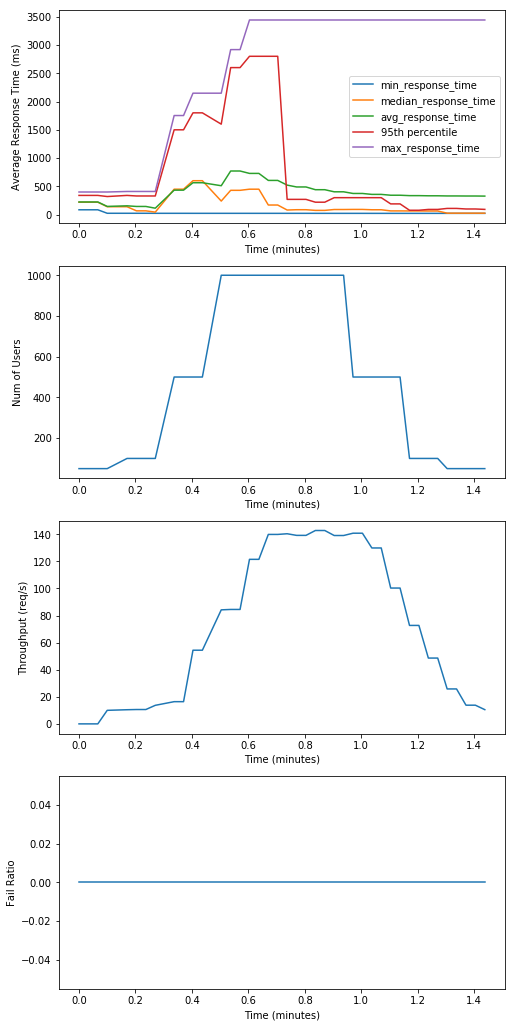

In [8]:
res = results

import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(8,18))
plt.subplot(411)
plt.plot(res['elapsed_min'], res['min_response_time'], label='min_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_percentile_50'], label='median_response_time')
plt.plot(res['elapsed_min'], res['avg_response_time'], label='avg_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_percentile_95'], label='95th percentile')
plt.plot(res['elapsed_min'], res['max_response_time'], label='max_response_time')

plt.xlabel('Time (minutes)')
plt.ylabel('Average Response Time (ms)')
plt.legend()

plt.subplot(412)
plt.plot(res['elapsed_min'], res['user_count'])
plt.xlabel('Time (minutes)')
plt.ylabel('Num of Users')

plt.subplot(413)
plt.plot(res['elapsed_min'], res['total_rps'])
plt.xlabel('Time (minutes)')
plt.ylabel('Throughput (req/s)')

plt.subplot(414)
plt.plot(res['elapsed_min'], res['fail_ratio'])
plt.xlabel('Time (minutes)')
plt.ylabel('Fail Ratio')

filename = filename.replace('.csv', '')
plt.savefig(filename + '.png', dpi=300)
plt.savefig(filename + '.pdf')
plt.show()